In [1]:
import numpy as np
import fortpy as fp
import tqdm as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')


In [2]:
class Output(object):
    def __init__(self, masses=[], positions=[], velocities=[], times=[],
                 coms=[], avvs=[], energies=[], amomentums=[], count=0,
                 n_recalculates=0):
        self.masses = masses
        self.positions = positions
        self.velocities = velocities
        self.times = times
        self.coms = coms
        self.avvs = avvs
        self.energies = energies
        self.amomentums = amomentums
        self.count = count
        self.n_recalculates = n_recalculates
        self.model_out = [self.masses, self.positions, self.velocities,
                          self.times, self.coms, self.avvs]

    def calculate_energy_momentum(self):
        """Computes the energy and angular momentum of a system of particles.
        The energy is computed as the kinetic energy of a particle minus the
        potential energy of every other particle relative to it. The angular
        momentum is the cross product of positions and velocities, relative to 
        the center of mass.
        """
        nrg_rel = np.zeros(self.positions.shape[0])
        h_rel = np.zeros(self.positions.shape[0])

        for i in range(self.positions.shape[1]):
            # if masses[i] != 0:
            nrg_rel += 0.5 * np.linalg.norm(self.velocities[:, i, :]
                                            - self.avvs, axis=1)**2
            for j in range(i+1, self.positions.shape[1]):
                # if masses[i] != 0:
                nrg_rel -= self.masses[i] / np.linalg.norm(
                    self.positions[:, i, :] - self.positions[:, j, :], axis=1
                    )
            h_rel += np.cross(self.positions[:, i, :2] - self.coms[:, :2],
                              self.velocities[:, i, :2] - self.avvs[:, :2],
                              axis=1)
        self.energies = nrg_rel
        self.amomentums = h_rel


def calc_com(masses, pos):
    """A simple function that compute the center of mass of a system
    """
    return (masses[:, None] * pos).sum(axis=0) / masses.sum()
    # return ((masses*pos.T).T).sum(axis = 0) / masses.sum()


def calc_avv(masses, vel):
    """A simple function that computes the average velocity of a system
    """
    return (masses[:, None] * vel).sum(axis=0) / masses.sum()
    # return ((masses*vel.T).T).sum(axis = 0) / masses.sum()
    
    
def n_body(integrator, masses, i_positions, i_velocities, t_tot, dt,
           update_com=True, **kwargs):
    """
    An n-body time integrator, that simulates the positions and velocities of
    an ensemble of particles in a gravity field.
    Inputs:
    integrator: A function that computes new positions and velocities, which
     takes masses, positions, velocities, and a timestep as inputs
    masses: A 1-D array of particle masses
    i_positions: A 2-D array of shape particles*dimensions of particle initial
    positions
    i_velocities: A 2-D array of shape particles*dimensions of particle initial
    velocities
    t_tot: A float of the total time of integration
    dt: The timestep
    
    Note: The integration is done using jacobi coordinates (ie relative to a 
     center of mass reference frame. If your inputs are not given in a center
     of mass reference frame, your inputs may not look like the initial state of
     the outputs)

    Outputs:
    positions, velocities, times, center of masses, average velocities, all
     as arrays. Positions and velocities are 3-D arrays of shape
     times*particles*dimensions. Times is a 1-D array of shape times. Center
     of mass and average velocities are of shape times*dimensions and only
     represent the change of the center of mass and velocity in the previous
     time step

    """
    # All the information we need to compute the times is given at the start
    n_steps = int(t_tot / dt)
    times = np.linspace(0., t_tot, n_steps + 1)
    positions = []
    velocities = []
    coms = []
    avvs = []
    # compute the center of mass and average velocities and update the inputs
    # before they are added to our data
    com = calc_com(masses, i_positions)
    avv = calc_avv(masses, i_velocities)
    if update_com:
        pos = i_positions - com
        vel = i_velocities - avv
    else:
        pos = i_positions
        vel = i_velocities
    for i, time in tqdm.tqdm(list(enumerate(times))):
        positions.append(pos)
        velocities.append(vel)
        coms.append(com)
        avvs.append(avv)
        out = integrator(masses, pos, vel, dt)
#         print(out)
        if len(out) == 2:
            pos, vel = out
        elif len(out) == 3:
            pos, vel = out[:2]
        elif len(out) == 4:
            pos, vel = out[2:]
            # In case you're using an adaptive integrator in 
            #n_body, this will allow it to run (good for testing)
        # To handle most critical bugs in any integrator function, this will
        # raise an error if the outputs are nonsense
        if np.any(np.isnan(pos)):
            raise ValueError('nan encountered')
        com = calc_com(masses, pos)
        avv = calc_avv(masses, vel)
        if update_com:
            pos -= com
            vel -= avv
    positions = np.array(positions)
    velocities = np.array(velocities)
    coms = np.array(coms)
    avvs = np.array(avvs)
    return Output(masses, positions, velocities, times, coms, avvs)

## Euler Tests

In [13]:
a = 1.0
T = 2. * np.pi
dt = 1e-2
t_tot = 10 * T

circle_i_pos = np.array([[0., 0., 0.], [1., 0., 0.]])
circle_i_vel = np.array([[0., 0., 0.], [0., 1., 0.]])
circle_masses = np.array([1., 0.])

euler_circle = n_body(fp.integrators.euler_forward, circle_masses,
                      circle_i_pos, circle_i_vel, t_tot, dt, update_com=True)
kdk_circle = n_body(fp.integrators.kdk, circle_masses,
                    circle_i_pos, circle_i_vel, t_tot, dt, update_com=True)
rk3_circle = n_body(fp.integrators.rk3_classic, circle_masses,
                    circle_i_pos, circle_i_vel, t_tot, dt, update_com=True)

100%|██████████| 6284/6284 [00:00<00:00, 9531.53it/s] 


In [14]:
kdk_circle.positions[:100, 1, 0]

array([1.        , 0.99994999, 0.99980003, 0.99955004, 0.99920011,
       0.99875027, 0.99820054, 0.99755096, 0.99680167, 0.99595267,
       0.99500412, 0.99395603, 0.99280858, 0.99156183, 0.9902159 ,
       0.98877096, 0.98722714, 0.98558462, 0.98384351, 0.98200405,
       0.98006636, 0.97803068, 0.97589719, 0.97366613, 0.97133768,
       0.96891212, 0.96638966, 0.96377057, 0.9610551 , 0.95824349,
       0.95533609, 0.95233315, 0.94923496, 0.94604188, 0.94275421,
       0.93937224, 0.93589634, 0.93232685, 0.92866415, 0.92490852,
       0.92106044, 0.91712022, 0.91308832, 0.90896511, 0.904751  ,
       0.90044641, 0.89605176, 0.89156753, 0.88699412, 0.88233203,
       0.87758172, 0.87274367, 0.8678183 , 0.86280614, 0.85770774,
       0.85252357, 0.84725416, 0.84189999, 0.83646166, 0.83093965,
       0.82533455, 0.81964695, 0.81387734, 0.80802637, 0.80209458,
       0.79608262, 0.78999102, 0.78382045, 0.7775715 , 0.77124476,
       0.7648409 , 0.75836056, 0.75180441, 0.7451731 , 0.73846

In [15]:
rk3_circle.positions[:100, 1, 0]

array([1.00000000e+00, 4.60938019e+11, 9.26439768e+11, 1.39650531e+12,
       1.87113459e+12, 2.35032753e+12, 2.83408413e+12, 3.32240467e+12,
       3.81528913e+12, 4.31273699e+12, 4.81474852e+12, 5.32132397e+12,
       5.83246388e+12, 6.34816718e+12, 6.86843390e+12, 7.39326506e+12,
       7.92265962e+12, 8.45661759e+12, 8.99513896e+12, 9.53822478e+12,
       1.00858740e+13, 1.06380866e+13, 1.11948627e+13, 1.17562042e+13,
       1.23221091e+13, 1.28925775e+13, 1.34676092e+13, 1.40472043e+13,
       1.46313629e+13, 1.52200869e+13, 1.58133723e+13, 1.64112231e+13,
       1.70136374e+13, 1.76206150e+13, 1.82321571e+13, 1.88482627e+13,
       1.94689316e+13, 2.00941639e+13, 2.07239596e+13, 2.13583187e+13,
       2.19972412e+13, 2.26407272e+13, 2.32887765e+13, 2.39413892e+13,
       2.45985695e+13, 2.52603133e+13, 2.59266162e+13, 2.65974868e+13,
       2.72729207e+13, 2.79529180e+13, 2.86374788e+13, 2.93266029e+13,
       3.00202905e+13, 3.07185414e+13, 3.14213600e+13, 3.21287377e+13,
      

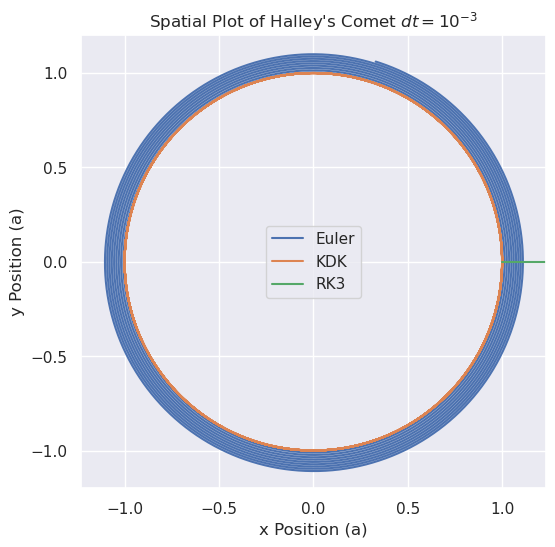

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
ax.plot(euler_circle.positions[:, 1, 0], euler_circle.positions[:, 1, 1],
        label='Euler')
ax.plot(kdk_circle.positions[:, 1, 0], kdk_circle.positions[:, 1, 1],
        label='KDK')
ax.plot(rk3_circle.positions[:, 1, 0], rk3_circle.positions[:, 1, 1],
        label='RK3')
ax.axis('equal')
ax.set_xlabel('x Position (a)')
ax.set_ylabel('y Position (a)')
ax.set_title(r"Spatial Plot of Halley's Comet $dt=10^{-3}$")
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.legend()

In [9]:
rk3_circle.positions[:, 1, 0]

array([1.00000000e+00, 1.18962391e+10, 2.38043628e+10, ...,
       2.42020999e+16, 2.42028601e+16, 2.42036203e+16])